In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import RobustScaler

### Loading dataset from csv file

In [8]:
df = pd.read_csv('./Dataset/creditcard.csv')

### Scale the time and amount features to match other pre-scaled features

In [9]:
robust_scaler = RobustScaler()

df['Amount'] = robust_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = robust_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,0
1,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,0
2,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,0
3,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,0
4,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,0


#### As we saw in the analysing phase. The dataset is highly imbalanced
- We will oversample the dataset by using SMOTE

In [10]:
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split

In [11]:
x = np.array(df.iloc[:, df.columns != 'Class'])
y = np.array(df.iloc[:, df.columns == 'Class'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

oversample = SMOTE(random_state=2)
x_train, y_train = oversample.fit_resample(x_train, y_train.ravel())

print("Counts of fradulent data: {}".format(sum(y_train==1)))
print("Counts of not-fradulent data: {}".format(sum(y_train==0)))

Counts of fradulent data: 227454
Counts of not-fradulent data: 227454


## Visualizing original and oversampled dataset

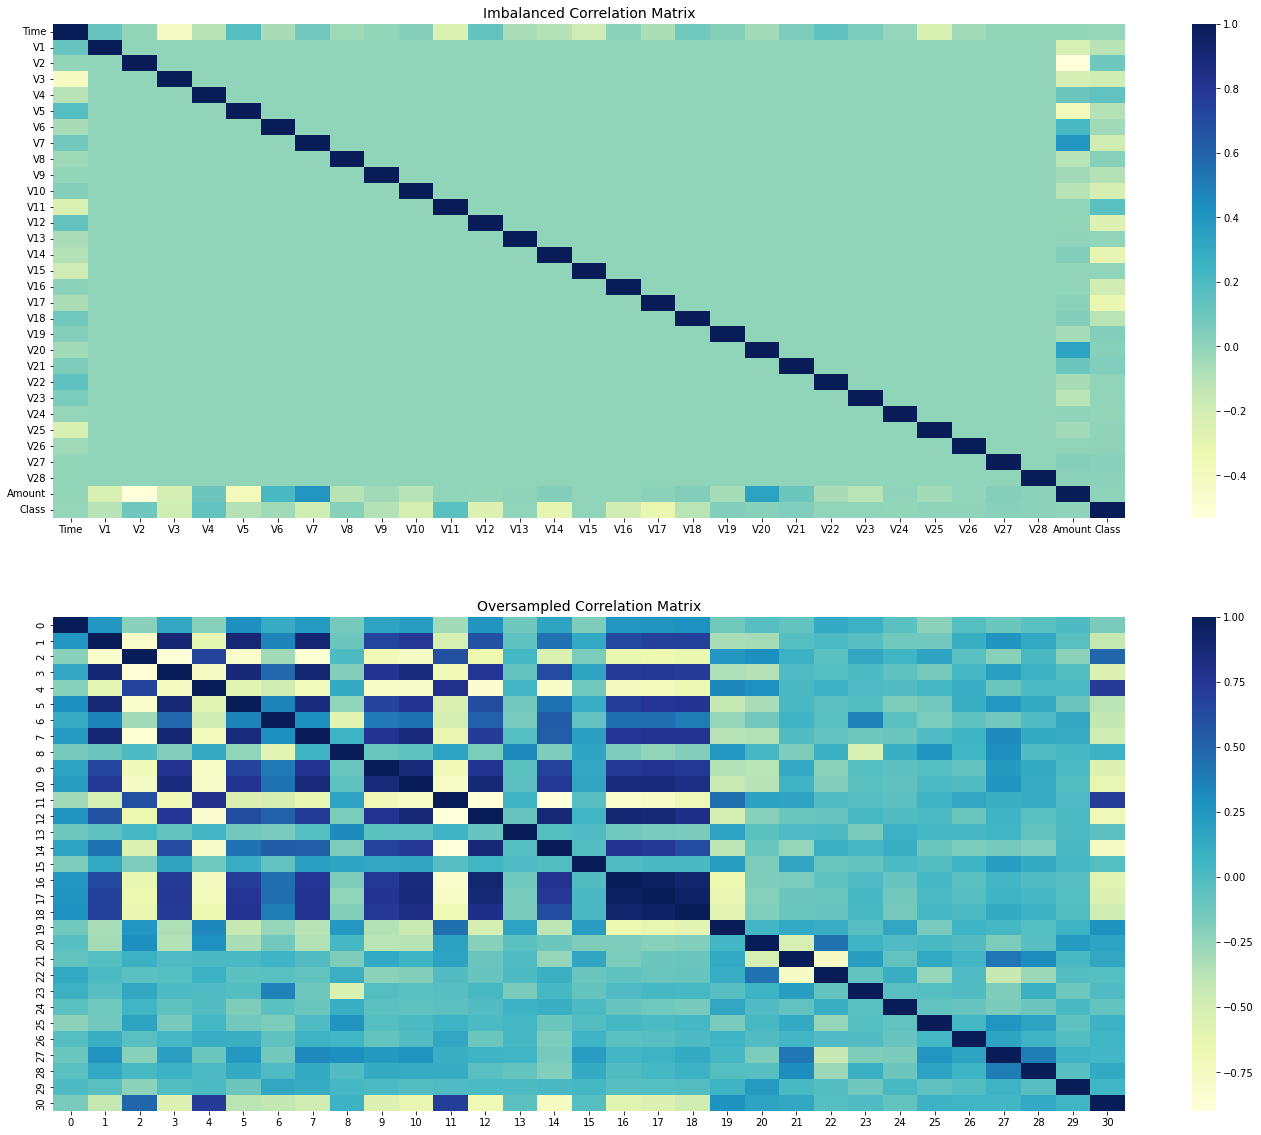

In [36]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Whole dataset
correlation = df.corr()
sns.heatmap(correlation, cmap='YlGnBu', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)

df2 = np.column_stack([x_train, y_train])

# Oversampled dataset
oversampled_correlation = pd.DataFrame(df2).corr()
sns.heatmap(oversampled_correlation, cmap='YlGnBu', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Oversampled Correlation Matrix', fontsize=14)
plt.show()

## Implementing the model

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [14]:
parameters = {
    'C': np.logspace(-3,3,10)
             }
logistic_regression = LogisticRegression()
classifier = GridSearchCV(logistic_regression, parameters, cv=5, verbose=5, n_jobs=3)
classifier.fit(x_train, y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             verbose=5)

In [15]:
classifier.best_params_

{'C': 46.41588833612773}

### Training the classifier with best parameters

In [16]:
classifier1 = LogisticRegression(C=46.41588833612773,penalty='l2', verbose=5)
classifier1.fit(x_train, y_train.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished


LogisticRegression(C=46.41588833612773, verbose=5)

## Evaluating the model

In [18]:
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, recall_score, classification_report, average_precision_score, precision_recall_curve

In [19]:
prediction = classifier1.predict(x_test)
print(classification_report(y_test, prediction, target_names=['No Fraud', 'Fraud']))

              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     56861
       Fraud       0.06      0.94      0.12       101

    accuracy                           0.98     56962
   macro avg       0.53      0.96      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [20]:
y_score = classifier1.decision_function(x_test)
avg_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score of the model: {0:0.2f}'.format(avg_precision))

Average precision-recall score: 0.78


Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.78')

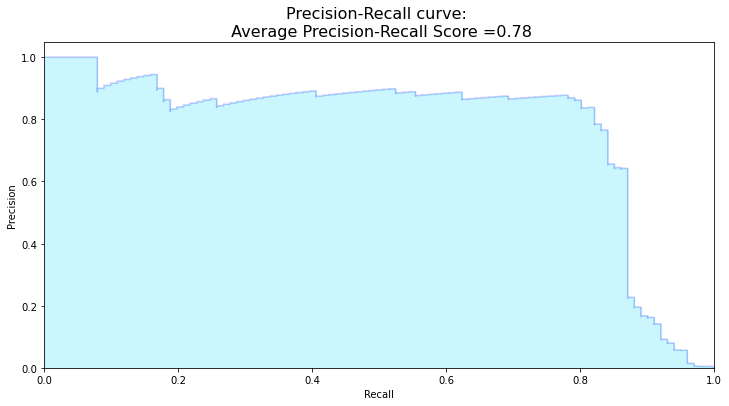

In [51]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#00d5f5')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [40]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('Ground truth')
    plt.xlabel('Predictions')

Recall metric of the train dataset: 91.4329930447475%
Normalized confusion matrix


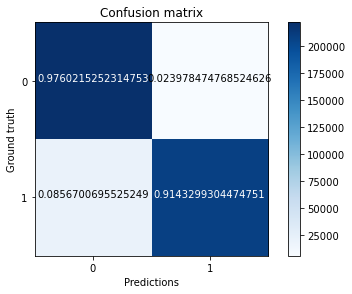

In [44]:
y_train_pre = classifier1.predict(x_train)

cnf_matrix = confusion_matrix(y_train, y_train_pre)

print("Recall metric of the train dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , normalize=True, classes=class_names, title='Confusion matrix')
plt.show()

Recall metric of the testing dataset: 94.05940594059406%
Precision metric of the testing dataset: 99.98918158706118%
Confusion matrix, without normalization


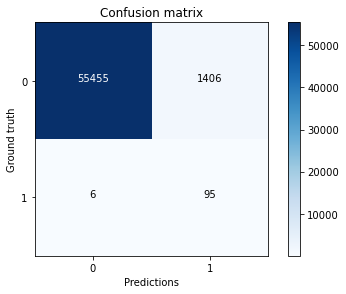

In [46]:
y_pre = classifier1.predict(x_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric of the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
print("Precision metric of the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


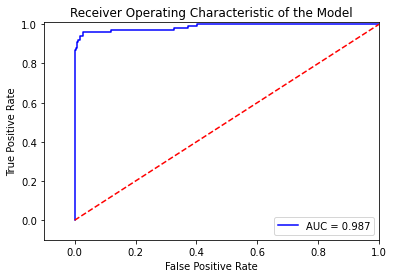

In [47]:
temp = classifier1.fit(x_train, y_train.ravel())
y_pred_score = temp.decision_function(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)

roc_auc = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic of the Model')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [26]:
roc_auc

0.9865316863548264